In [1]:
# Load libs:
import datetime as dt
import os
import sys
from glob import glob
from os.path import abspath, dirname, exists, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from amplify.data import DataGenerator, DataSplit
from clearml import Task

In [47]:
ewm_data = DataSplit(DataGenerator().load_data(), sequence=False).split_data()

Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Info: Successfully merged Building and Weather data!
Info: Calculating Azimuth and Irradiance data, this may take awhile...
Info: Successfully added Azimuth and Irradiance data!
Info: Converting Cyclical Features.
Info: Successfully converted cyclical features! Data is ready!
Info: Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y), (norm_layer)!


In [203]:
from sklearn import linear_model, metrics


# Build class for EWM Linear Regression to compare scaled/non-scaled features
class Baseline_Models:
    def __init__(
        self,
        tuple_of_tuples,
        y_vars: list = ["Solar", "Usage"],
        span: int = 24,
    ):

        (
            (self.train_x, self.train_y),
            (self.val_x, self.val_y),
            (self.test_x, self.test_y),
            self._,
        ) = tuple_of_tuples
        self.y_vars = y_vars
        self.span = span

        # Create two DFs for collecting outputs
        self.ewm_test_pred = pd.DataFrame(self.test_y).rename(
            columns={
                0: "Solar Actual",
                1: "Usage Actual",
            }
        )
        self.ewm_val_pred = pd.DataFrame(self.val_y).rename(
            columns={
                0: "Solar Actual",
                1: "Usage Actual",
            }
        )

    # Reversed-Recombined EWMA for improved accuracy
    def _ewm_averager(self):
        # Create dataframe To collect data
        self.ewm_out = pd.DataFrame()

        for i, y in enumerate(self.y_vars):
            # Calculate fwd and bwd EWMA
            self.ewm_out["fwd"] = (
                pd.DataFrame(self.train_y[:, i]).ewm(span=self.span).mean()
            )
            self.ewm_out["bwd"] = (
                pd.DataFrame(self.train_y[:, i][::-1]).ewm(span=self.span).mean()
            )

            # Reversed-Recombined EWMA
            self.ewm_out[str(y) + "_combo"] = self.ewm_out[["fwd", "bwd"]].mean(axis=1)
            self.ewm_out = self.ewm_out.drop(["fwd", "bwd"], axis=1)

        return self.ewm_out

    def _lin_reg_ewma(self, data):
        self.data = data

        for i, y in enumerate(self.y_vars):
            # On to the regression:
            self.lin_reg = linear_model.LinearRegression()
            self.lin_reg.fit(self.train_x, self.data[str(y) + "_combo"])

            self.ewm_val_pred[str(y) + "_ewm_val"] = self.lin_reg.predict(self.val_x)
            self.ewm_test_pred[str(y) + "_ewm_test"] = self.lin_reg.predict(self.test_x)

        return (self.ewm_val_pred, self.ewm_test_pred)

    def _models(self):
        self.ewm_y = self._ewm_averager()
        self.ewm_out = self._lin_reg_ewma(self.ewm_y)

        return self.ewm_out

    def eval_metrics_func(self, y_true, y_pred):
        self.y_true, self.y_pred = y_true, y_pred

        print("Evaluation metric results:-")
        print(f"MSE is : {metrics.mean_squared_error(self.y_true, self.y_pred)}")
        print(f"MAE is : {metrics.mean_absolute_error(self.y_true, self.y_pred)}")
        print(
            f"RMSE is : {np.sqrt(metrics.mean_squared_error(self.y_true, self.y_pred))}"
        )
        print(
            f"MAPE is : {np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100}"
        )
        print(f"R2 is : {metrics.r2_score(self.y_true, self.y_pred)}", end="\n\n")

In [204]:
baseline = Baseline_Models(ewm_data, span=1)
val_pred, test_pred = baseline._models()

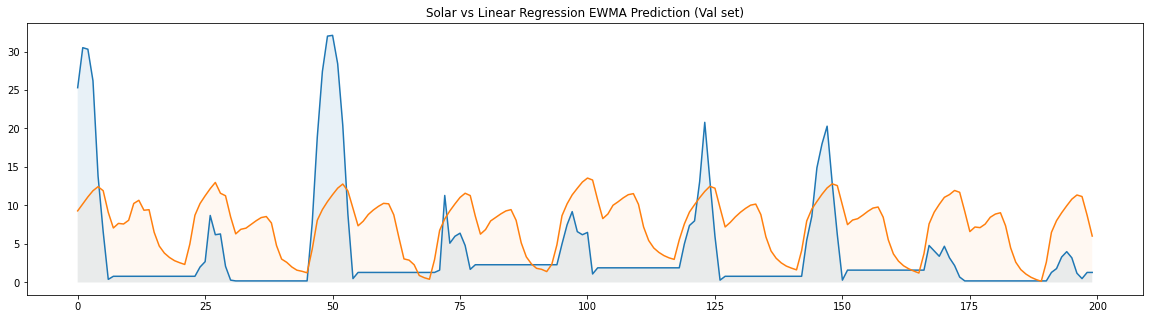

<Figure size 432x288 with 0 Axes>

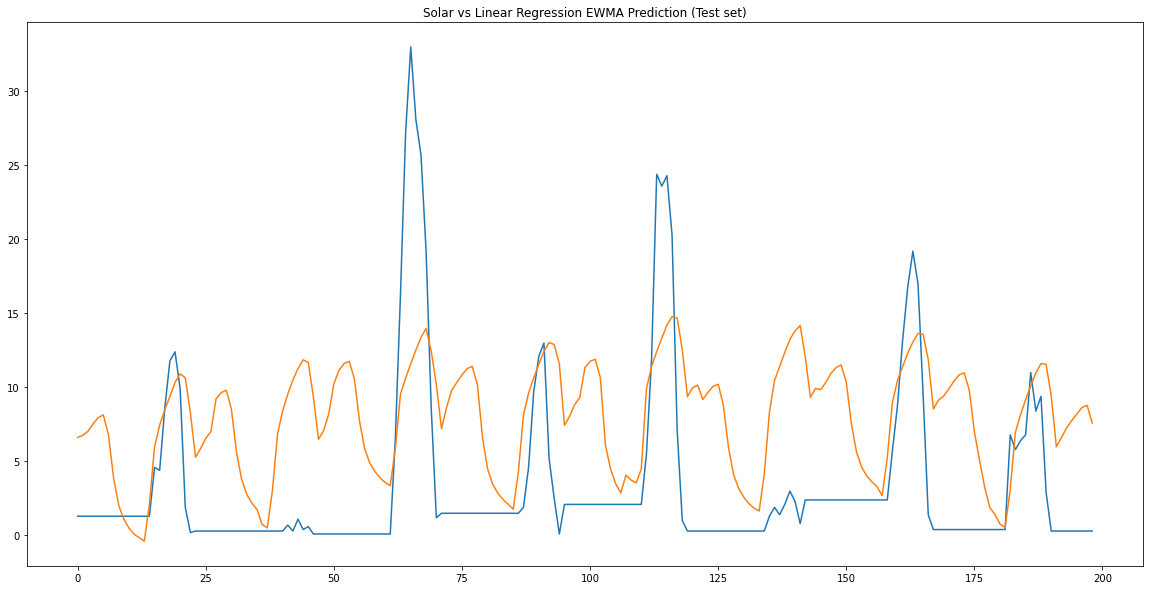

<Figure size 432x288 with 0 Axes>

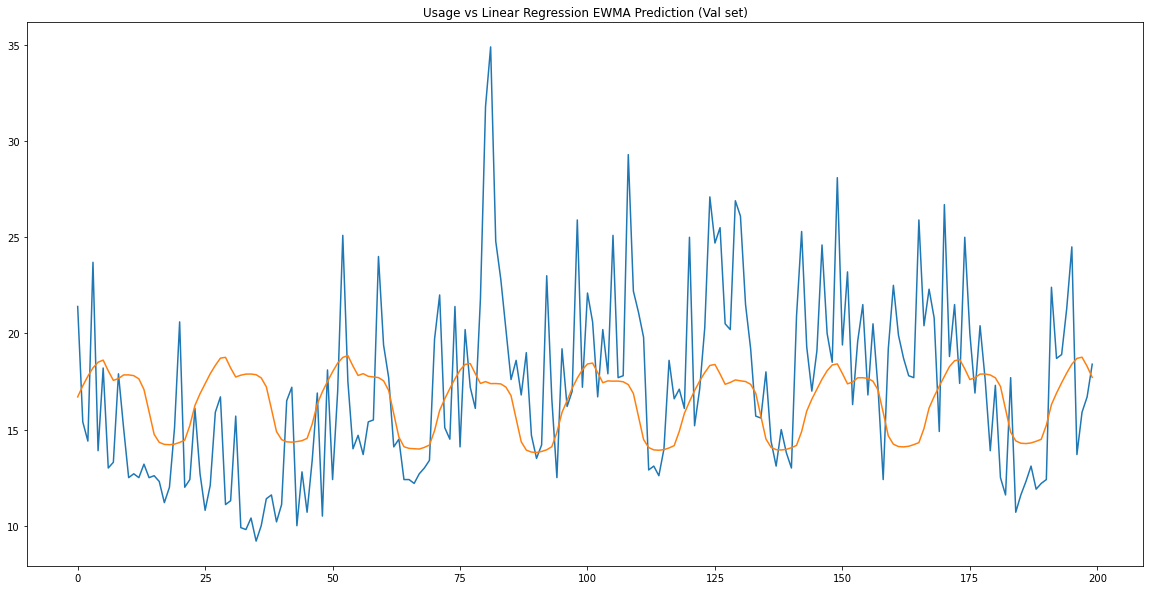

<Figure size 432x288 with 0 Axes>

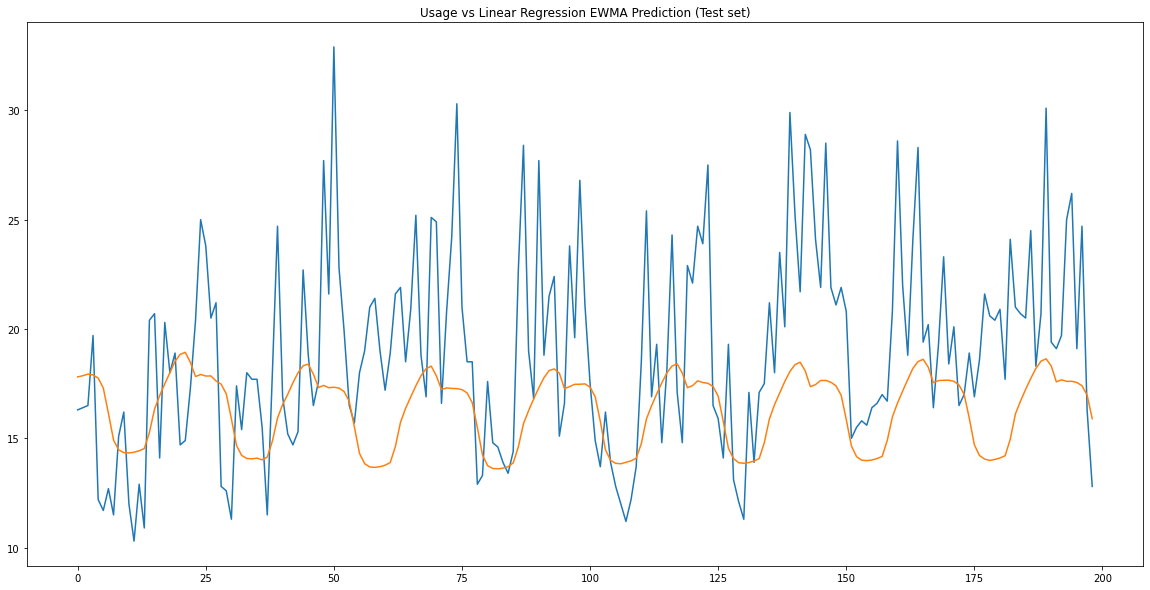

<Figure size 432x288 with 0 Axes>

In [212]:
plt.figure(figsize=(20, 5))

plt.fill_between(val_pred.index, val_pred["Solar Actual"], 0, alpha=0.1)
plt.fill_between(val_pred.index, val_pred["Solar_ewm_val"], 0, alpha=0.05)
plt.plot(val_pred[["Solar Actual", "Solar_ewm_val"]])

plt.title("Solar vs Linear Regression EWMA Prediction (Val set)")
plt.show()
plt.clf()

plt.figure(figsize=(20, 10))
plt.plot(test_pred[["Solar Actual", "Solar_ewm_test"]])
plt.title("Solar vs Linear Regression EWMA Prediction (Test set)")
plt.show()
plt.clf()

plt.figure(figsize=(20, 10))
plt.plot(val_pred[["Usage Actual", "Usage_ewm_val"]])
plt.title("Usage vs Linear Regression EWMA Prediction (Val set)")
plt.show()
plt.clf()

plt.figure(figsize=(20, 10))
plt.plot(test_pred[["Usage Actual", "Usage_ewm_test"]])
plt.title("Usage vs Linear Regression EWMA Prediction (Test set)")
plt.show()
plt.clf()

In [205]:
print("Solar Val set metrics")
baseline.eval_metrics_func(val_pred["Solar Actual"], val_pred["Solar_ewm_val"])
print("Solar Test set metrics")
baseline.eval_metrics_func(test_pred["Solar Actual"], test_pred["Solar_ewm_test"])

print("Usage Val set metrics")
baseline.eval_metrics_func(val_pred["Usage Actual"], val_pred["Usage_ewm_val"])
print("Usage Test set metrics")
baseline.eval_metrics_func(test_pred["Usage Actual"], test_pred["Usage_ewm_test"])

Solar Val set metrics
Evaluation metric results:-
MSE is : 48.70159149169922
MAE is : 5.732111930847168
RMSE is : 6.978652477264404
MAPE is : 725.2008438110352
R2 is : -0.17309506816452136

Solar Test set metrics
Evaluation metric results:-
MSE is : 49.79468536376953
MAE is : 5.927788257598877
RMSE is : 7.056534767150879
MAPE is : 1413.260555267334
R2 is : -0.40966975978501785

Usage Val set metrics
Evaluation metric results:-
MSE is : 20.8520565032959
MAE is : 3.5593743324279785
RMSE is : 4.566405296325684
MAPE is : 21.077735722064972
R2 is : 0.056668058706952795

Usage Test set metrics
Evaluation metric results:-
MSE is : 23.66353988647461
MAE is : 3.795213222503662
RMSE is : 4.864518642425537
MAPE is : 18.612094223499298
R2 is : -0.15463787540986007



In [222]:
#### The output we care about:

diff_df = pd.DataFrame(val_pred["Solar Actual"] - val_pred["Usage Actual"]).rename(
    columns={0: "Actual"}
)
diff_df["actual_bool"] = diff_df.Actual > 0

<AxesSubplot:>

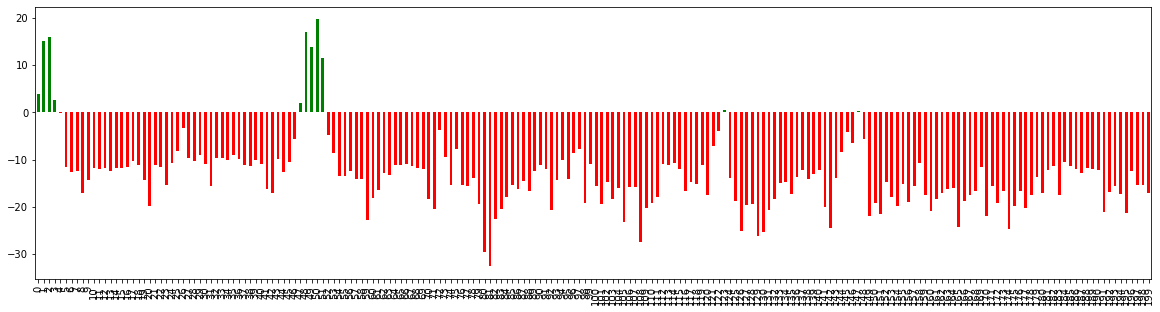

In [230]:
plt.figure(figsize=(20, 5))
diff_df.Actual.plot(kind="bar", color=diff_df.actual_bool.map({True: "g", False: "r"}))

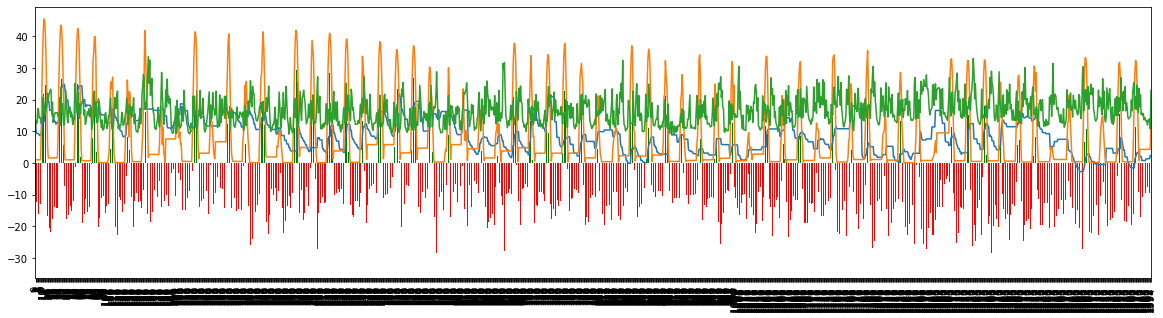

In [279]:
train_diff = pd.DataFrame(train_ds[1][:, 0] - train_ds[1][:, 1]).rename(
    columns={0: "actual_diff"}
)
train_diff["cmap"] = train_ds[1][:, 0] > train_ds[1][:, 1]

plt.figure(figsize=(20, 5))
train_diff.actual_diff.plot(
    kind="bar", color=train_diff.cmap.map({True: "g", False: "r"})
)

plt.figure(figsize=(20, 10))
plt.plot(train_ds[0][:, 0])
plt.plot(train_ds[1])

plt.show()

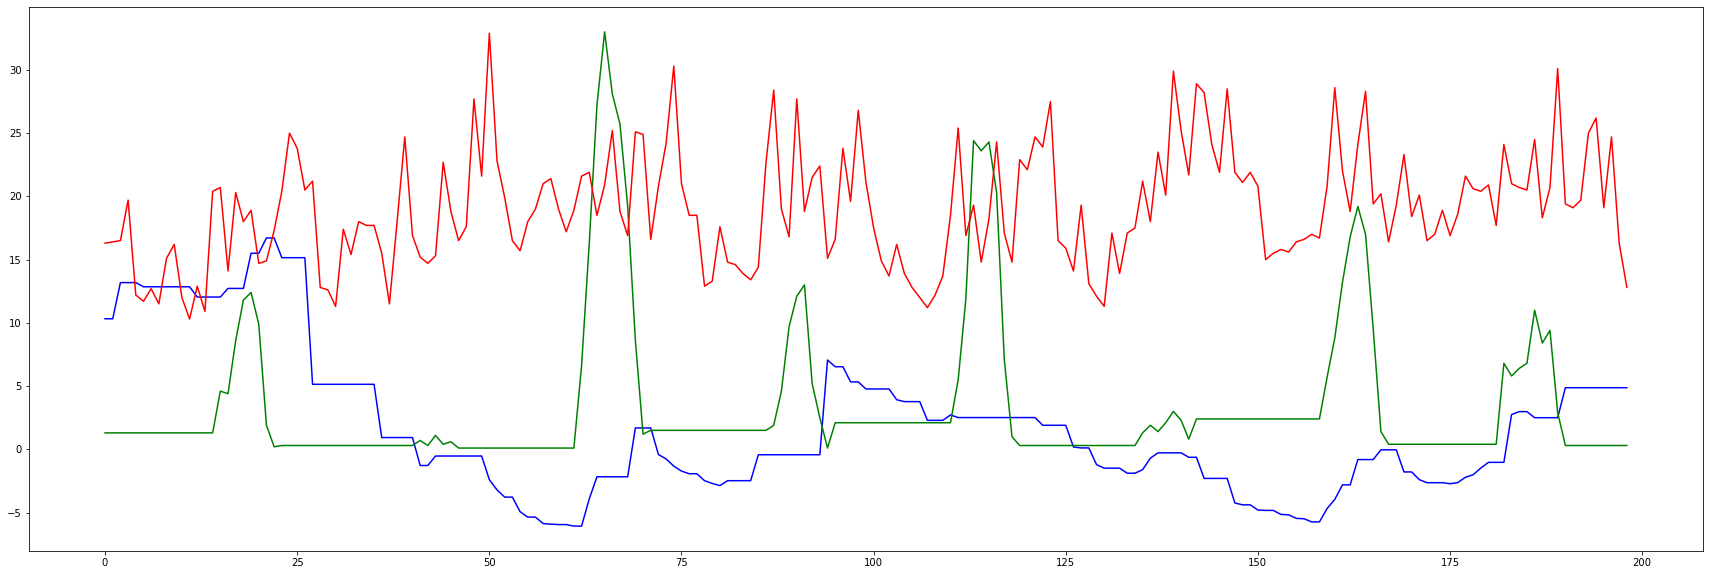

In [286]:
plt.figure(figsize=(30, 10))
plt.plot(test_ds[0][:, 0], color="b", label="temp")
plt.plot(test_ds[1][:, 0], color="g", label="solar")
plt.plot(test_ds[1][:, 1], color="r", label="usage")

Text(0, 0.5, 'usage')

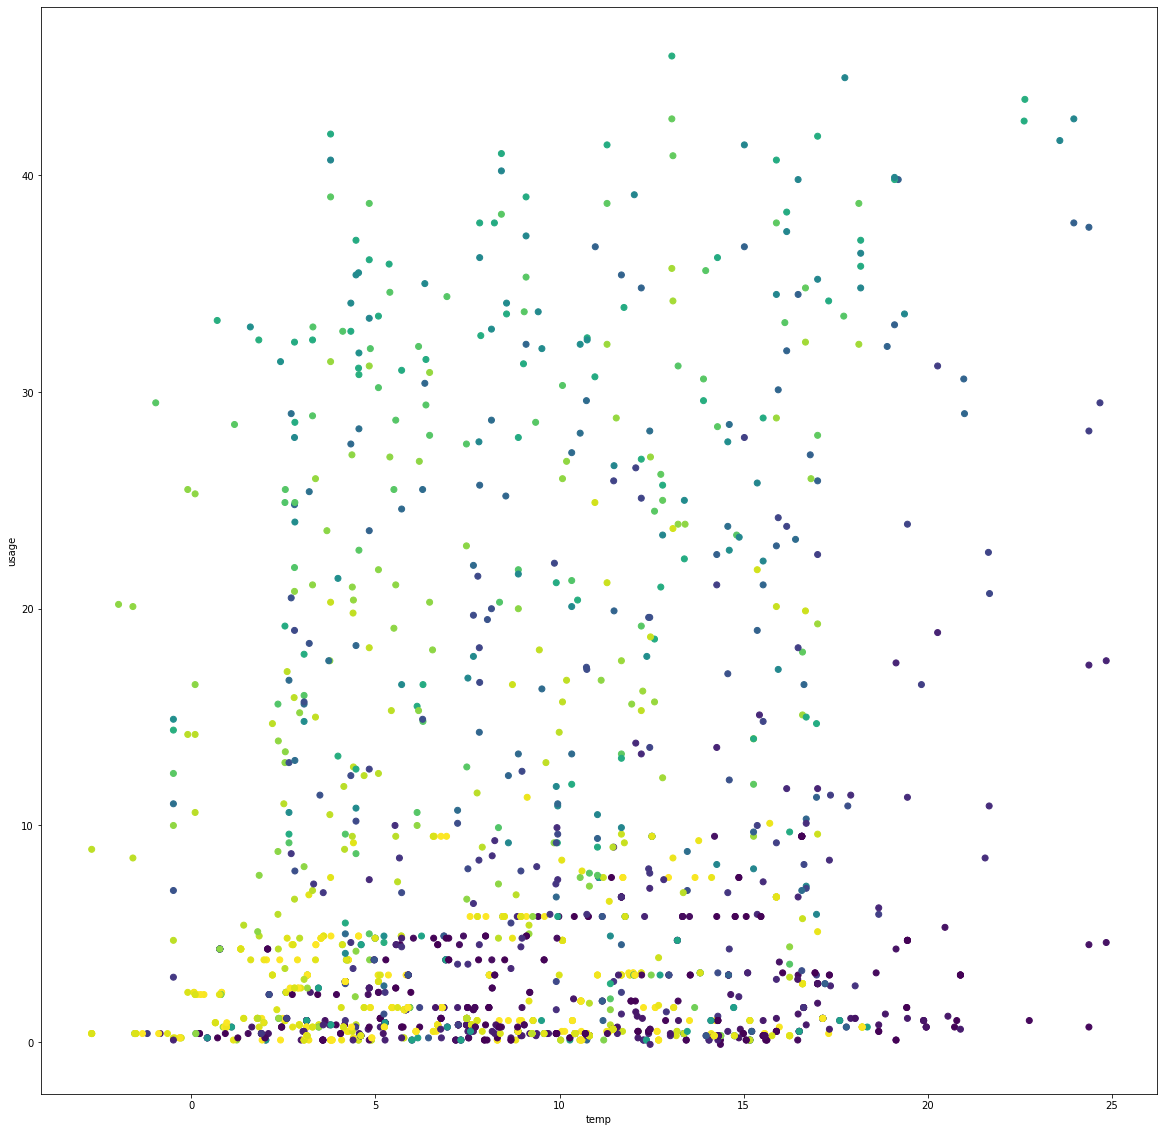

In [297]:
plt.figure(figsize=(20, 20))
plt.scatter(train_ds[0][:, 0], train_ds[1][:, 0], c=train_ds[0][:, 3], cmap="viridis")
plt.xlabel("temp")
plt.ylabel("usage")